In [1]:
import json
import numpy as np

In [2]:
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
root_folder = '/home/lyt/code/vqa-concept'
data_folder = '{}/dataTVQA'.format(root_folder)
fea_folder = '{}/image-feature/bottomup'.format(data_folder)
img_folder = '/home/data/lyt/TextVQA/train_images'
img_folder_test = '/home/data/lyt/TextVQA/test_images'

In [4]:
def get_emb(emb_file):
    with open(emb_file) as f:
        raw = f.read().splitlines()
    word_vec = [l.split(' ', 1) for l in raw]
    vocab, vecs_txt = zip(*word_vec)
    vecs = np.fromstring(' '.join(vecs_txt), dtype='float32', sep=' ')
    vecs = vecs.reshape(-1, 300)
    emb_dict = dict(zip(vocab, vecs))
    return emb_dict, np.mean(vecs), np.std(vecs)

In [5]:
emb_file = '{}/word-embedding/glove.6B.300d.txt'.format(data_folder)
emb_dict, mean, std = get_emb(emb_file)

In [6]:
#=======================================

In [7]:
split_name = 'test'
if split_name == 'test':
    img_folder = img_folder_test
jsdata = json.load(open('{}/TextVQA_0.5_{}.json'.format(data_folder, split_name),'r'))
print(jsdata.keys())

dict_keys(['dataset_type', 'dataset_name', 'dataset_version', 'data'])


In [8]:
for k in jsdata.keys():
    if k != 'data':
        print('{}: {}'.format(k,jsdata[k]))

dataset_type: test
dataset_name: textvqa
dataset_version: 0.5


In [9]:
data = jsdata['data']
print(len(data),type(data))

5734 <class 'list'>


In [10]:
pair = data[3]
pair.keys()

dict_keys(['question', 'image_id', 'image_classes', 'flickr_original_url', 'flickr_300k_url', 'image_width', 'image_height', 'ocr_tokens', 'ocr_info', 'question_tokens', 'question_id', 'set_name'])

In [11]:
for k in pair.keys():
    if k != 'ocr_info':
        print('{}: {}'.format(k,pair[k]))

question: who makes the phone?
image_id: a644c4c46d7c0b0f
image_classes: ['Laptop', 'Mobile phone']
flickr_original_url: https://c8.staticflickr.com/3/2490/4082192766_947a9ba3f8_o.jpg
flickr_300k_url: https://c2.staticflickr.com/3/2490/4082192766_54d583035d_z.jpg
image_width: 1024
image_height: 768
ocr_tokens: ['MOTOROLA', 'ווון', '김']
question_tokens: ['who', 'makes', 'the', 'phone']
question_id: 39605
set_name: test


In [12]:
print(len(pair['ocr_tokens']))
print(pair['ocr_tokens'])
ocr_info =  pair['ocr_info']
print(type(ocr_info))
print(ocr_info[0].keys())

3
['MOTOROLA', 'ווון', '김']
<class 'list'>
dict_keys(['word', 'bounding_box'])


In [13]:
word = ocr_info[0]['word']
print(word)

MOTOROLA


In [14]:
bbox = ocr_info[0]['bounding_box']
print(bbox)

{'top_left_x': 0.11577741056681, 'top_left_y': 0.43198761343956, 'width': 0.12308093160391, 'height': 0.059577669948339, 'rotation': 0, 'yaw': -79.441184997559, 'roll': 0, 'pitch': 0}


In [15]:
img = imread('{}/{}.jpg'.format(img_folder, pair['image_id']))

(768, 1024, 3)


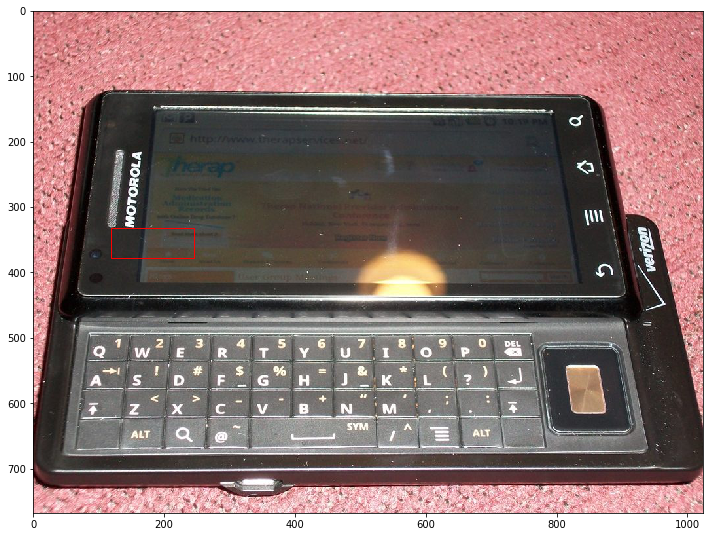

In [16]:
print(img.shape)
fig,ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)
ax.add_patch(Rectangle((round(bbox['top_left_x']*pair['image_width']),round(bbox['top_left_y']*pair['image_height'])),
                       round(bbox['width']*pair['image_width']),round(bbox['height']*pair['image_height']),
                       linewidth=1,edgecolor='r',facecolor='none'))
plt.show()

In [17]:
#------save im_id:ocr_information------

In [18]:
im_ocr = {}
for pair in data:
    im_id = pair['image_id']
    if im_id not in im_ocr:
        im_ocr[im_id] = {'image_classes': pair['image_classes'],
                         'image_width': pair['image_width'],
                         'image_height': pair['image_height'],
                         'ocr_tokens': pair['ocr_tokens'],
                         'ocr_info': pair['ocr_info']}
json.dump(im_ocr, open('{}/ocr_{}.json'.format(data_folder, split_name),'w'))

In [19]:
len(im_ocr)

3289

In [20]:
im_ids = np.load('{}/{}_100_id.npy'.format(fea_folder, split_name))
print(im_ids.shape)

(3289,)


In [21]:
emb_size = next(iter(emb_dict.values())).shape[0]
ocr_num = 50
ocr_emb = np.random.randn(im_ids.shape[0], ocr_num, emb_size).astype('float32')
ocr_emb = (ocr_emb + mean) * std
fill_cnt = 0
for i,imid in enumerate(im_ids):
    all_ocr = im_ocr[imid]['ocr_tokens']
    num = min(ocr_num,len(all_ocr))
    for j in range(num):
        words = all_ocr[j].strip().lower().split()
        act = 0
        emb = np.zeros((emb_size,), dtype='float32')
        for w in words:
            if w in emb_dict:
                act += 1
                emb += emb_dict[w]
            if act > 0:
                emb /= act
                ocr_emb[i][j] = emb
                fill_cnt += 1
print('fill embedding: {}/{}'.format(fill_cnt, im_ids.shape[0]*ocr_num))

fill embedding: 15197/164450


In [22]:
np.save('{}/ocr_glove/{}_{}_ocr.npy'.format(fea_folder, split_name, ocr_num), ocr_emb)